https://www.kaggle.com/johnolafenwa/us-census-data  
  
https://christophm.github.io/interpretable-ml-book/  

https://github.com/slundberg/shap/issues/397

# Explainable Machine learning
The purpose of this notebook is to take a deep dive into methods for explaining black box models. You see a fair amount of machine learning models implemented online, but little attention is given to the explainability of such models to the users and stakeholders. In industry, more attention needs to be given to the output as users often want to know the reason for a specific prediction. For example, if you were to predict my salary based on features such as job title, work experience, location, etc. then I would like to know how they contributed to the final result. Is work experience more important than the job I apply for? Do you see the same relationship if you were make the prediction for someone else? In other words, which features are important in general and which are important specific to my prediction? 
  
Several methods will be discussed in detail, but a focus will be on Partial Dependency Plots and SHAP values as those are commonly used (relatively) simple to implement in businesses.   

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)  
<br>
2. [Preprocess Data](#preprocess)  

    2.1 [Load Data](#load)
    
    2.2 [NaN Values (i.e., " ?")](#nan)
    
    2.3 [Preprocessing Steps](#preprocessing)
3. [EDA](#eda)  

    3.1 [Categorical Variables](#categorical)
    
    3.2 [Target Variable](#target)
4. [Modeling](#Modeling)  

    4.1 [Accuracy](#accuracy)
    
    4.2 [F1-score](#f1)
    
    4.3 [Balanced Accuracy](#balanced)
5. [Partial Dependency Plots (PDP)](#dpd)  

    5.1 [Assumptions](#accuracy)
    
    5.2 [Correlation Matrix](#correlation)
    
    5.3 [Correlation Matrix - One-hot encoding](#correlation-one)

    5.4 [PDP - Single feature](#pdp-single)
    
    5.5 [PDP - One-hot encoding](#pdp-one)
    
    5.6 [PDP - Interaction](#pdp-interaction)
6. [Local Interpretable Model-agnostic Explanations (LIME)](#lime)  
<br>
6. [SHAP](#shap)  

## <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Interpretable ML
import shap
from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def load_data(path):
    # Load in data
    column_names = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_num', 
                    'Marital_status', 'Occupation', 'Relationship', 'Race', 'Gender', 
                    'Capital_gain', 'Capital_loss', 'Hours/Week', 'Native_country', 
                    'Income_bracket']
    raw_df = pd.read_csv(path, header=None, names=column_names)
    return raw_df

def preprocess_data(raw_df):
    column_names = raw_df.columns
    df = raw_df.copy() 
    
    # Remove NaN (i.e., ?) values
    for i in df.columns:
        if ' ?' in df[i].unique():
            df[i].replace(' ?', np.nan, inplace=True)
    df.dropna(inplace=True)
    
    # Merge primary school values
    primary = [' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th']
    df['Education'] = df.apply(lambda row: "Primary" if row.Education in primary else row.Education, 1)

    # Get one-hot encoding of non-float/int columns
    one_hot_encoded_columns = pd.get_dummies(raw_df[column_names[:-1]])
    df = df.drop(column_names[:-1],axis = 1)
    df = df.join(one_hot_encoded_columns)

    # Label income bracket and remove fnlwgt column
    df.Income_bracket = df.Income_bracket.map({' <=50K':0, ' >50K': 1})
    df = df.drop('fnlwgt', axis=1)
    
    # Rename occupation columns
    columns_to_change = [i for i in df.columns if 'Occupation' in i]
    columns_to_change_into = ["O_"+i.split("_")[1] for i in df.columns if 'Occupation' in i]
    columns_dict = {i: j for i, j in zip(columns_to_change, columns_to_change_into)}
    df.rename(columns_dict, axis = 1, inplace=True)
    
    return df

## <a name="preprocess">2. Preprocess Data</a> 
[Back to Table of Contents](#table)

I do some data preprocessing to make sure that it is all in the right format for making the predictions. 

#### <a name="load">2.1 Load Data</a> 
[Back to Table of Contents](#table)

The raw data is loaded in with the right naming of the columns. 

In [3]:
raw_df = load_data("data.csv")

#### <a name="nan">2.2 NaN Values (i.e., " ?")</a> 
[Back to Table of Contents](#table)

However, some columns have a "?" in them which seems to be actually missing values. Thus, we need to replace those with NaNs and then drop them. 

In [4]:
for i in raw_df.columns:
    if ' ?' in raw_df[i].unique():
        print(i)

Workclass
Occupation
Native_country


In [5]:
raw_df.replace(" ?", np.nan, inplace=True)
print("{} missing values in the data.".format(sum(raw_df.isnull().sum())))

4262 missing values in the data.


#### <a name="preprocessing">2.3 Preprocessing Steps</a> 
[Back to Table of Contents](#table)

* Merge primary school values together (1st-4th, 5th-6th, 7th-8th, 9th, 10th, 11th, 12th)
* Some values have a " ?" which should be replaced by NaN
* Drop rows with NaN
* Apply one hot encoding
* Target (0 = <=50k, 1 = >50k)
* Drop fnlwgt

In [6]:
df = preprocess_data(raw_df)

## <a name="eda">3. EDA</a> 
[Back to Table of Contents](#table)

#### <a name="categorical">3.1 Categorical Features</a> 
[Back to Table of Contents](#table)

Note that there are many categorical variables with each many categories.   
I typically like to use one-hot encoding to make sure the data can be read correctly without assuming some sort of distance between categories.   Fortunately, this is a small dataset which allows for the creation of many features.  
If the data were bigger than I would cluster/chunk some categorical values together as those that happen infrequently are likely not too carry much predictive power. 

In [7]:
raw_df.head()

Age          Workclass  fnlwgt   Education  Education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital_status          Occupation    Relationship    Race   Gender  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital_gain  Capital_loss  Hours/Week  Native_country Income_bracket  
0          2174             0          40   United-States          <=50K  
1             0             0          13   United-States          <=50K  
2             0             0          40   United-States          <=50K  
3             0             0          40   United-States          <=50K  
4             0             0          40            Cuba          <=50K

In [8]:
for column in ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Gender', 'Native_country']:
    print("{} unique categories in {}".format(len(raw_df[column].unique()), column))
print("\n{} additional columns are created".format(len(df.columns)-len(raw_df.columns)))

9 unique categories in Workclass
16 unique categories in Education
7 unique categories in Marital_status
15 unique categories in Occupation
6 unique categories in Relationship
5 unique categories in Race
2 unique categories in Gender
42 unique categories in Native_country

90 additional columns are created


In [9]:
df.head()

Income_bracket  Age  Education_num  Capital_gain  Capital_loss  Hours/Week  \
0               0   39             13          2174             0          40   
1               0   50             13             0             0          13   
2               0   38              9             0             0          40   
3               0   53              7             0             0          40   
4               0   28             13             0             0          40   

   Workclass_ Federal-gov  Workclass_ Local-gov  Workclass_ Never-worked  \
0                       0                     0                        0   
1                       0                     0                        0   
2                       0                     0                        0   
3                       0                     0                        0   
4                       0                     0                        0   

   Workclass_ Private  ...  Native_country_ Portugal  \
0                   0  ...                         0   
1                   0  ...                         0   
2                   1  ...                         0   
3                   1  ...                         0   
4                   1  ...                         0   

   Native_country_ Puerto-Rico  Native_country_ Scotland  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   Native_country_ South  Native_country_ Taiwan  Native_country_ Thailand  \
0                      0                       0                         0   
1                      0                       0                         0   
2                      0                       0                         0   
3                      0                       0                         0   
4                      0                       0                         0   

   Native_country_ Trinadad&Tobago  Native_country_ United-States  \
0                                0                              1   
1                                0                              1   
2                                0                              1   
3                                0                              1   
4                                0                              0   

   Native_country_ Vietnam  Native_country_ Yugoslavia  
0                        0                           0  
1                        0                           0  
2                        0                           0  
3                        0                           0  
4                        0                           0  

[5 rows x 105 columns]

#### <a name="target">3.2 Target Variable</a> 
[Back to Table of Contents](#table)

In [10]:
df.Income_bracket.value_counts()

0    22654
1     7508
Name: Income_bracket, dtype: int64

There is some inbalance with respect to the target variable. Thus, we need to be careful interpreting a simple accuracy measure as it does not take the inbalance into account. Instead, we can use F1-score or even balanced accuracy (macro-average recall). 

## <a name="Modeling">4. Modeling</a> 
[Back to Table of Contents](#table)

In [11]:
# The join moved the target column (Income_bracket) to the beginning
X = df[df.columns[1:]]
y = df[df.columns[0]]

# Train model
clf = LGBMClassifier(random_state=0, n_estimators=100)
fitted_clf = clf.fit(X, y)

#### <a name="accuracy">4.1 Accuracy</a> 
[Back to Table of Contents](#table)

In [12]:
scores = cross_val_score(clf, X, y, cv=10); np.mean(scores)

0.8701683441984965

#### <a name="f1">4.2 F1-score</a> 
[Back to Table of Contents](#table)

<img src = https://wikimedia.org/api/rest_v1/media/math/render/svg/057ffc6b4fa80dc1c0e1f2f1f6b598c38cdd7c23>

In [13]:
scores = cross_val_score(clf, X, y, cv=10, scoring="f1"); np.mean(scores)

0.717601583598631

#### <a name="balanced">4.3 Balanced Accuracy</a> 
[Back to Table of Contents](#table)

This basically balances the class weights to have equal impact when calculating the accuracy.   
You can see it as the average of recall obtained on each class. 

In [14]:
scores = cross_val_score(clf, X, y, cv=10, scoring="balanced_accuracy"); np.mean(scores)

0.8008365156368829

You can clearly see the differences between scoring measures.  
It is important to understand to spend sufficient time on validating the performance of your model.  
You do not want to be surprised by poor results after you put the model into production (API, Flask application, Docker, etc.)

## <a name="dpd">5. Dependency Plot</a> 
[Back to Table of Contents](#table)

Partial Dependency Plots (DPD) show the effect a feature has on the outcome of a predictive based model.   
It marginalizes the model output over the distribution of features in order to extract the importance of the feature of interest. 
This importance calculation is based on an important assumption, namely that the feature of interest is not correlated with all other features (except for the target). The reason for this is that it will show data points that are likely to be impossible. For example, weight and height are correlated but the PDP might show the effect of a large weight and very small height on the target while that combination is highly unlikely. This can be partially resolved by showing a rug at the bottom of your PDP. 

#### <a name="assumptions">5.1 Assumptions</a> 
[Back to Table of Contents](#table)
* The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.
* When the features are correlated, we create new data points in areas of the feature distribution where the actual probability is very low (for example it is unlikely that someone is 2 meters tall but weighs less than 50 kg).

https://christophm.github.io/interpretable-ml-book/pdp.html

#### <a name="correlation">5.2 Correlation Matrix</a> 
[Back to Table of Contents](#table)  
Below the correlation matrix is shown between features to give an indication of whether the assumption of independence is violated or not. From these features one can conclude that there seems to be no violation seeing as features are not highly correlated. 

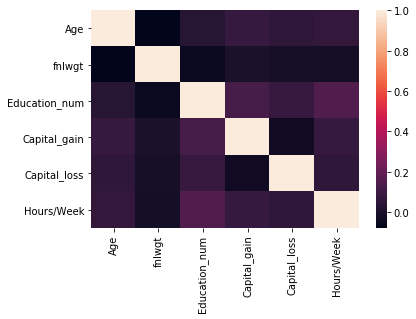

In [15]:
# calculate the correlation matrix
corr = raw_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### <a name="correlation-one">5.3 Correlation - One-hot Encoding</a> 
[Back to Table of Contents](#table)

However, the results might differ when we look into the one-hot encoded features. Since we isolate certain characteristics of a single feature by encoding it, new relationships might be discovered. Therefore, it would be worthwhile to at least check the correlations between encoded features. 

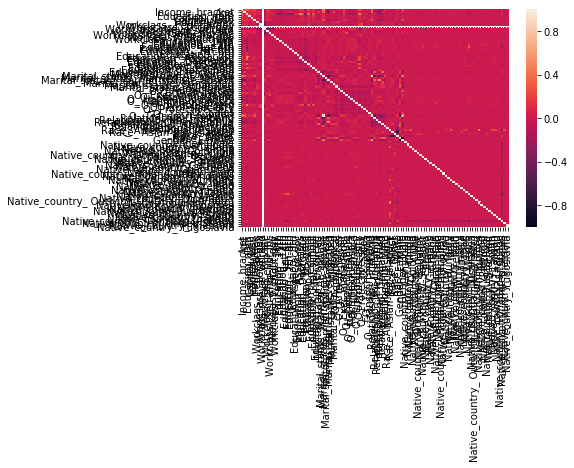

In [16]:
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Clearly, showing the correlation matrix between these many does not work if there are only a few correlated features. Thus, instead I simply extract the features that have the highest absolute correlation by unstacking the correlation matrix and quicksorting it. 

In [17]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
df_corr = pd.DataFrame(so).reset_index().dropna()
df_corr.columns = ['feature1', 'feature2', 'r']
df_corr = df_corr[df_corr.r < 1].sort_values('r', ascending=False)
df_corr.head(10)

feature1                            feature2  \
10709  Marital_status_ Married-civ-spouse               Relationship_ Husband   
10708               Relationship_ Husband  Marital_status_ Married-civ-spouse   
10707                         Race_ White                         Race_ Black   
10706                         Race_ Black                         Race_ White   
10705       Marital_status_ Never-married  Marital_status_ Married-civ-spouse   
10704  Marital_status_ Married-civ-spouse       Marital_status_ Never-married   
10702                        Gender_ Male               Relationship_ Husband   
10700               Relationship_ Husband                      Gender_ Female   
10701               Relationship_ Husband                        Gender_ Male   
10703                      Gender_ Female               Relationship_ Husband   

              r  
10709  0.896502  
10708  0.896502  
10707  0.794808  
10706  0.794808  
10705  0.644862  
10704  0.644862  
10702  0.581221  
10700  0.581221  
10701  0.581221  
10703  0.581221

We can see some obvious correlated features such as Race_White and Race_Black. The encoding of features results in the creation of features that are almost by definition correlated simply because those categorical values can only take 1 value. Thus, if your Race isn't White, then you obviously are more likely to be Black. 

#### <a name="pdp-single">5.4 PDP - Single feature</a> 
[Back to Table of Contents](#table)

The PDP plot for the feature "Age" shows that until the age of 50 there is a higher chance of earning more as a persons age increases. However, after the age of 50 we see this trend going the other direction, namely that age has a negative effect on the likelihood of earning more. 

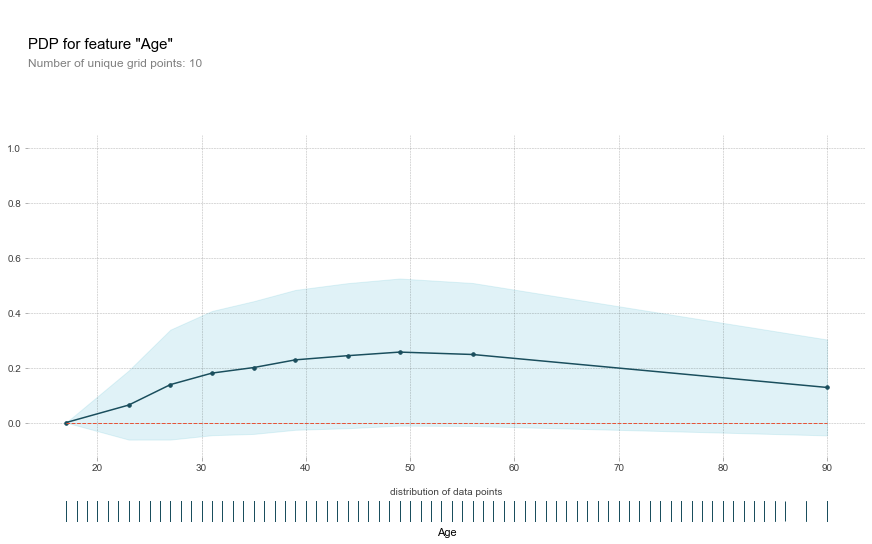

In [18]:
pdp_fare = pdp.pdp_isolate(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], feature='Age'
)
fig, axes = pdp.pdp_plot(pdp_fare, 'Age', plot_pts_dist=True)

#### <a name="pdp-one">5.5 PDP - One-hot encoding</a> 
[Back to Table of Contents](#table)

The next step is to check what would happen if we would look at categorical values that were one-hot encoded. To demonstrate this effect we take of the features that represent "Relationship" and plot those in the PDP. The results show that especially when somebody is in the Other-relative relationship there is a decreased chance of earning more. You could do the same for 

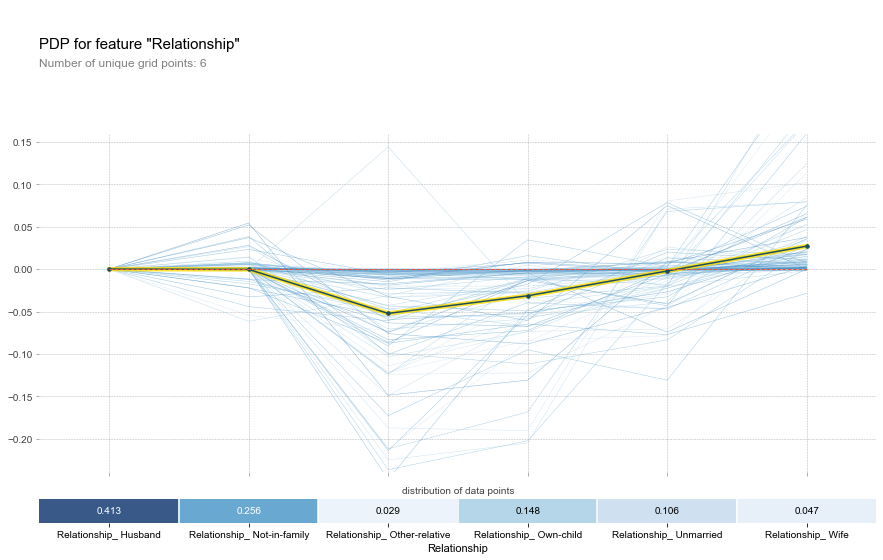

In [19]:
pdp_relationship = pdp.pdp_isolate(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], 
    feature=[i for i in df.columns if 'Relationship' in i]
)
fig, axes = pdp.pdp_plot(pdp_relationship, 'Relationship', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True,
                        plot_params = {'xticks_rotation': 111120})

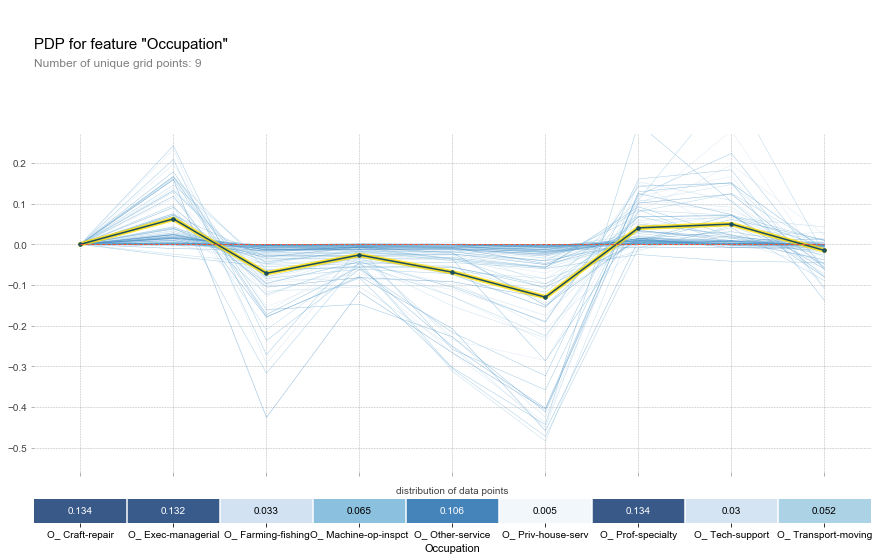

In [20]:
pdp_race = pdp.pdp_isolate(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], 
    feature=[i for i in df.columns if 'O_' in i if i not in ['O_ Adm-clerical', 'O_ Armed-Forces', 'O_ Armed-Forces', 
                                                             'O_ Protective-serv', 'O_ Sales', 'O_ Handlers-cleaners']]
)
fig, axes = pdp.pdp_plot(pdp_race, 'Occupation', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True,
                        plot_params = {'xticks_rotation': 111120})

#### <a name="pdp-interaction">5.6 PDP - Interaction</a> 
[Back to Table of Contents](#table)

Lastly, I decided to show the interaction between Age and Hours/Week. As you can see younger people are more likely to make less money. With age comes a higher chance of making more money. However, Age does seem to interact with Hours/Week seeing as there is a "sweet spot" when it comes to an increased chance of earning more than 50K. Specifically, this seems to be when Age is around 49 and that person works between 48 and 52 Hours/Week. Finally, the model seemed to have learnt that any age over (roughly) 65 results in basically the same kind of prediction. In practice, there might be some nuances to that seeing as it is based on the quantiles of the features. There is likely to be few instances of people over 56 in the dataset. 

In [38]:
print("{}% of the data is of people over the age of 65".format(round(len(df[df.Age>65])/len(df)*100)))

3% of the data is of people over the age of 65


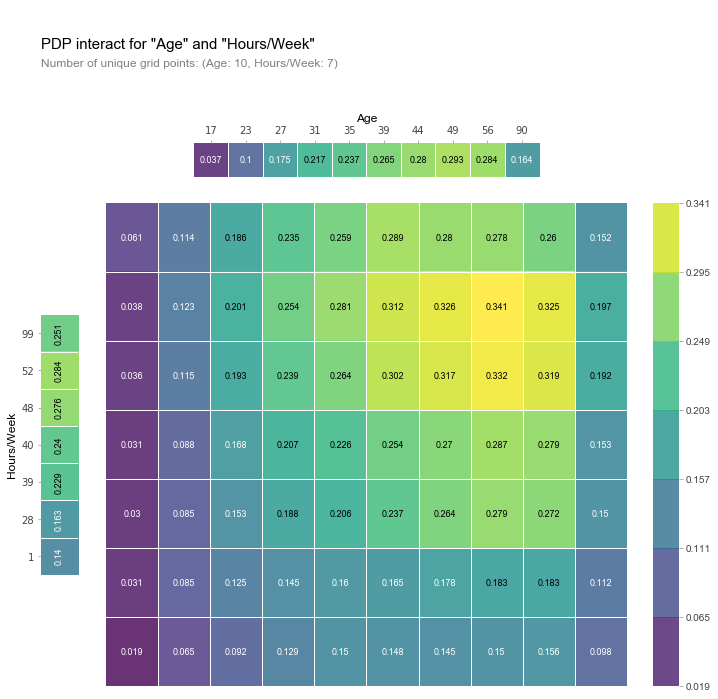

In [22]:
inter1 = pdp.pdp_interact(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], features=['Age', 'Hours/Week']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['Age', 'Hours/Week'], plot_type='grid', x_quantile=True, plot_pdp=True
)

## <a name="lime">6. Local Interpretable Model-agnostic Explanations (LIME)</a> 
[Back to Table of Contents](#table)

LIME basically tries to step away from deriving the importance of global features and instead approximates the importance of features for local predictions. It does so by taking the row (or set of datapoints) from which to predict and generate fake data based on that row. It then calculates the similarity between the fake data and the real data and approximates the effect of the changes. Some fake rows might be very different from the initial real row and therefore the feature importances should not be weighted strongly. Instead, fake rows with slight changes are more important since they better represent the initial row. Thus, simply create a bunch of fake data, throw it into the classifier and see how much the prediction changes based on the similarity between rows. 


**Reference**  
Ribeiro, M. T., Singh, S., & Guestrin, C. (2016, August). Why should i trust you?: Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1135-1144). ACM.

See https://arxiv.org/abs/1602.04938 for the full article

In [41]:
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, class_names=["<=50K", ">50K"], discretize_continuous=True,
                                kernel_width=5)

#### <a name="lime-0">6.1 Predicting less than 50K</a> 
[Back to Table of Contents](#table)

In the visualization below you can seen the effect of the top 5 features on the probabilities of the target variable. As you can see Capital Gain has a large influence on whether somebody makes less money which makes sense seeing as it is directly related to ones investments. 

In [24]:
i = 12000
exp = explainer.explain_instance(X.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)
print("True value: {}".format(y[i]))

True value: 0


**Values when predicting >50K**

In [25]:
i = np.random.randint(0, X.shape[0])
i = 8
exp = explainer.explain_instance(X.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)
print("True value: {}".format(y[i]))

True value: 1


**Disadvantage**

The neighborhood around which LIME tries to find different values for the initial row is, to an extend, a hyperparameter that can be optimized. At times you want a larger neighborhood depending on the data. It is a bit of trial and error to find the right kernel width. 

**Instability of Explanations (Repeating Predictions)**

## <a name="shap">7. SHAP</a> 
[Back to Table of Contents](#table)

In [11]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(X)

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

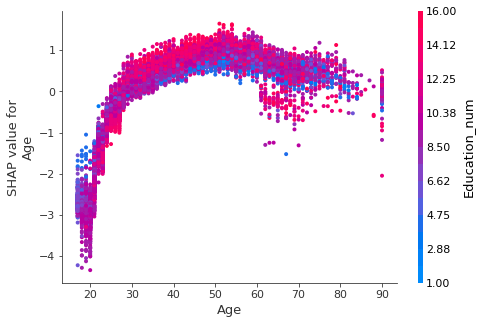

In [13]:
shap.dependence_plot("Age", shap_values, X)

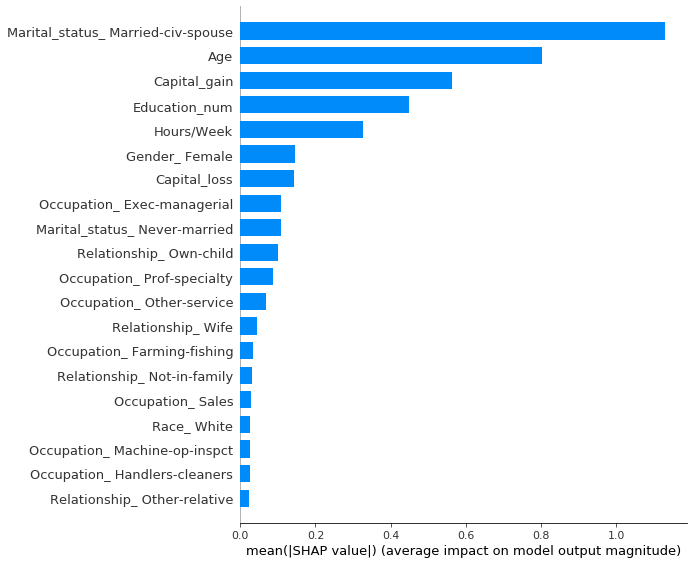

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")

**Additivity SHAP values (categorical variables)**